In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /content/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.models import Model
from keras.layers import *
from keras.layers.merge import concatenate

In [0]:
def one_by_one_cnn(filtersNumber, inputLayer, dropout = 0.2):
    one_by_one = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    one_by_one = BatchNormalization()(one_by_one)
    one_by_one = SpatialDropout1D(dropout)(one_by_one)
    
    return one_by_one

In [0]:
def one_by_three_cnn(filtersNumber, inputLayer, dropout = 0.2):
    one_by_one = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    one_by_one = BatchNormalization()(one_by_one)
    one_by_one = SpatialDropout1D(dropout)(one_by_one)
    
    return one_by_one

In [0]:
def yoon_kim_pool(filtersNumber, inputLayer):
    block_1_conv_1 = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_max_pool1 = MaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filtersNumber, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_max_pool2 = MaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_max_pool3 = MaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filtersNumber, 5, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_max_pool4 = MaxPooling1D()(block_1_batchnorm4)

    block_1_features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    
    block_1_features = Dropout(0.2)(block_1_features)
    return block_1_features

In [0]:
def yoon_kim_feature_extractor(filtersNumber, inputLayer):
    block_1_conv_1 = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filtersNumber, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filtersNumber, 5, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    block_1_features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    block_1_features = Dropout(0.2)(block_1_features)
    return block_1_features

In [12]:
maxWords = 30000
maxSequenceLengthInWords = 400
embeddingDimension = 300
convBlocks = 1

input_layer = Input(shape=(maxSequenceLengthInWords,))

pretrained_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

embedding = Average()([pretrained_embedding_layer, custom_embedding_layer])
embedding_dropout = SpatialDropout1D(0.2)(embedding)

preprocess = one_by_one_cnn(300, embedding_dropout)
preprocess = one_by_one_cnn(300, preprocess)

block = preprocess
for currentBlock in range(convBlocks):
  filters = 128 * (2 + currentBlock)
  block = one_by_three_cnn(filters, block)
  if(currentBlock < convBlocks-1):
    block = yoon_kim_pool(filters, block)
  
features = yoon_kim_feature_extractor(512, block)

dense_1 = Dense(256, activation = 'elu')(features)
dense_1_normalization = BatchNormalization()(dense_1)
dense_1_dropout = Dropout(0.2)(dense_1_normalization)

dense_2 = Dense(256, activation = 'elu')(dense_1_dropout)
dense_2_normalization = BatchNormalization()(dense_2)
dense_2_dropout = Dropout(0.2)(dense_2_normalization)

output_layer = Dense(6, activation='sigmoid')(dense_2_dropout)

model = Model(inputs=[input_layer], outputs=[output_layer])
            
model.summary()

model.compile(
    loss='binary_crossentropy', 
    optimizer='Adam',
    metrics=['accuracy']
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [13]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 21408/102124 [=====>........................] - ETA: 7:53 - loss: 0.1818 - acc: 0.9305

102112/102124 [============================>.] - ETA: 0s - loss: 0.0900 - acc: 0.9669

102124/102124 [==============================] - 624s 6ms/step - loss: 0.0900 - acc: 0.9669 - val_loss: 0.0495 - val_acc: 0.9820
Epoch 2/32
 14048/102124 [===>..........................] - ETA: 8:21 - loss: 0.0619 - acc: 0.9775

 58624/102124 [================>.............] - ETA: 4:08 - loss: 0.0584 - acc: 0.9788

102112/102124 [============================>.] - ETA: 0s - loss: 0.0572 - acc: 0.9790

102124/102124 [==============================] - 628s 6ms/step - loss: 0.0572 - acc: 0.9790 - val_loss: 0.0471 - val_acc: 0.9826
roc-auc: 0.9769 - roc-auc_val: 0.9762                                                                                                    
Epoch 3/32
  8736/102124 [=>............................] - ETA: 8:48 - loss: 0.0509 - acc: 0.9812

102112/102124 [============================>.] - ETA: 0s - loss: 0.0527 - acc: 0.9804

102124/102124 [==============================] - 619s 6ms/step - loss: 0.0527 - acc: 0.9804 - val_loss: 0.0433 - val_acc: 0.9835
Epoch 4/32
 13888/102124 [===>..........................] - ETA: 8:24 - loss: 0.0524 - acc: 0.9801

 58528/102124 [================>.............] - ETA: 4:06 - loss: 0.0502 - acc: 0.9810

102112/102124 [============================>.] - ETA: 0s - loss: 0.0495 - acc: 0.9812

102124/102124 [==============================] - 620s 6ms/step - loss: 0.0495 - acc: 0.9812 - val_loss: 0.0423 - val_acc: 0.9834
roc-auc: 0.9862 - roc-auc_val: 0.9827                                                                                                    
Epoch 5/32
  8736/102124 [=>............................] - ETA: 8:38 - loss: 0.0475 - acc: 0.9818

102112/102124 [============================>.] - ETA: 0s - loss: 0.0475 - acc: 0.9819

102124/102124 [==============================] - 618s 6ms/step - loss: 0.0475 - acc: 0.9819 - val_loss: 0.0424 - val_acc: 0.9841
Epoch 6/32
 14048/102124 [===>..........................] - ETA: 8:17 - loss: 0.0475 - acc: 0.9820

 94912/102124 [==========================>...] - ETA: 40s - loss: 0.0465 - acc: 0.9822

102124/102124 [==============================] - 622s 6ms/step - loss: 0.0464 - acc: 0.9823 - val_loss: 0.0434 - val_acc: 0.9839

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00029730176902376115.
roc-auc: 0.9855 - roc-auc_val: 0.9828                                                                                                    
Epoch 7/32
  5664/102124 [>.............................] - ETA: 9:12 - loss: 0.0430 - acc: 0.9826

102112/102124 [============================>.] - ETA: 0s - loss: 0.0447 - acc: 0.9828

102124/102124 [==============================] - 621s 6ms/step - loss: 0.0447 - acc: 0.9828 - val_loss: 0.0433 - val_acc: 0.9834
Epoch 8/32
 14048/102124 [===>..........................] - ETA: 8:18 - loss: 0.0415 - acc: 0.9842

102112/102124 [============================>.] - ETA: 0s - loss: 0.0437 - acc: 0.9832

102124/102124 [==============================] - 620s 6ms/step - loss: 0.0437 - acc: 0.9832 - val_loss: 0.0434 - val_acc: 0.9838
roc-auc: 0.9863 - roc-auc_val: 0.9847                                                                                                    
Epoch 9/32
  8704/102124 [=>............................] - ETA: 8:58 - loss: 0.0422 - acc: 0.9836

 46208/102124 [============>.................] - ETA: 5:20 - loss: 0.0423 - acc: 0.9833

102112/102124 [============================>.] - ETA: 0s - loss: 0.0424 - acc: 0.9834

102124/102124 [==============================] - 624s 6ms/step - loss: 0.0424 - acc: 0.9834 - val_loss: 0.0405 - val_acc: 0.9842
Epoch 10/32
 13984/102124 [===>..........................] - ETA: 8:18 - loss: 0.0398 - acc: 0.9846

 62720/102124 [=================>............] - ETA: 3:42 - loss: 0.0412 - acc: 0.9840

102112/102124 [============================>.] - ETA: 0s - loss: 0.0415 - acc: 0.9838

102124/102124 [==============================] - 619s 6ms/step - loss: 0.0415 - acc: 0.9838 - val_loss: 0.0402 - val_acc: 0.9842
roc-auc: 0.9925 - roc-auc_val: 0.9872                                                                                                    
Epoch 11/32
  8704/102124 [=>............................] - ETA: 8:49 - loss: 0.0394 - acc: 0.9848

 69152/102124 [===================>..........] - ETA: 3:08 - loss: 0.0407 - acc: 0.9839

102124/102124 [==============================] - 626s 6ms/step - loss: 0.0407 - acc: 0.9840 - val_loss: 0.0405 - val_acc: 0.9842
Epoch 12/32
  1408/102124 [..............................] - ETA: 9:25 - loss: 0.0409 - acc: 0.9833

102112/102124 [============================>.] - ETA: 0s - loss: 0.0400 - acc: 0.9840

102124/102124 [==============================] - 618s 6ms/step - loss: 0.0400 - acc: 0.9840 - val_loss: 0.0407 - val_acc: 0.9845
roc-auc: 0.992 - roc-auc_val: 0.9868                                                                                                    
Epoch 13/32
  8736/102124 [=>............................] - ETA: 8:52 - loss: 0.0372 - acc: 0.9848

 51232/102124 [==============>...............] - ETA: 4:50 - loss: 0.0387 - acc: 0.9845

 89856/102124 [=========================>....] - ETA: 1:10 - loss: 0.0394 - acc: 0.9844

102124/102124 [==============================] - 627s 6ms/step - loss: 0.0394 - acc: 0.9844 - val_loss: 0.0403 - val_acc: 0.9843
Epoch 14/32
  9344/102124 [=>............................] - ETA: 8:44 - loss: 0.0385 - acc: 0.9843

 91520/102124 [=========================>....] - ETA: 59s - loss: 0.0384 - acc: 0.9847 

102124/102124 [==============================] - 621s 6ms/step - loss: 0.0387 - acc: 0.9846 - val_loss: 0.0398 - val_acc: 0.9843
roc-auc: 0.9939 - roc-auc_val: 0.9876                                                                                                    
Epoch 15/32
  6240/102124 [>.............................] - ETA: 8:53 - loss: 0.0382 - acc: 0.9850

102112/102124 [============================>.] - ETA: 0s - loss: 0.0380 - acc: 0.9849

102124/102124 [==============================] - 614s 6ms/step - loss: 0.0380 - acc: 0.9849 - val_loss: 0.0406 - val_acc: 0.9843
Epoch 16/32
 13984/102124 [===>..........................] - ETA: 8:09 - loss: 0.0373 - acc: 0.9854

102112/102124 [============================>.] - ETA: 0s - loss: 0.0374 - acc: 0.9850

102124/102124 [==============================] - 619s 6ms/step - loss: 0.0374 - acc: 0.9850 - val_loss: 0.0407 - val_acc: 0.9843
roc-auc: 0.994 - roc-auc_val: 0.9866                                                                                                    
Epoch 17/32
  8736/102124 [=>............................] - ETA: 8:55 - loss: 0.0364 - acc: 0.9850

 75712/102124 [=====================>........] - ETA: 2:30 - loss: 0.0374 - acc: 0.9849

102124/102124 [==============================] - 622s 6ms/step - loss: 0.0370 - acc: 0.9851 - val_loss: 0.0402 - val_acc: 0.9844

Epoch 00017: ReduceLROnPlateau reducing learning rate to 9.473228419665247e-05.
Epoch 18/32
  2912/102124 [..............................] - ETA: 9:21 - loss: 0.0336 - acc: 0.9870

102112/102124 [============================>.] - ETA: 0s - loss: 0.0360 - acc: 0.9856

102124/102124 [==============================] - 621s 6ms/step - loss: 0.0360 - acc: 0.9856 - val_loss: 0.0410 - val_acc: 0.9843
roc-auc: 0.9947 - roc-auc_val: 0.9865                                                                                                    
Epoch 19/32
  8704/102124 [=>............................] - ETA: 8:51 - loss: 0.0369 - acc: 0.9849

102112/102124 [============================>.] - ETA: 0s - loss: 0.0358 - acc: 0.9855

102124/102124 [==============================] - 623s 6ms/step - loss: 0.0358 - acc: 0.9855 - val_loss: 0.0403 - val_acc: 0.9846
Epoch 20/32
 13984/102124 [===>..........................] - ETA: 8:21 - loss: 0.0356 - acc: 0.9855

 98144/102124 [===========================>..] - ETA: 22s - loss: 0.0357 - acc: 0.9855

102124/102124 [==============================] - 627s 6ms/step - loss: 0.0357 - acc: 0.9855 - val_loss: 0.0409 - val_acc: 0.9845
roc-auc: 0.9948 - roc-auc_val: 0.9856                                                                                                    
Epoch 21/32
  7776/102124 [=>............................] - ETA: 8:54 - loss: 0.0364 - acc: 0.9852

 74016/102124 [====================>.........] - ETA: 2:38 - loss: 0.0348 - acc: 0.9859

102124/102124 [==============================] - 621s 6ms/step - loss: 0.0349 - acc: 0.9860 - val_loss: 0.0405 - val_acc: 0.9847
Epoch 22/32
  3264/102124 [..............................] - ETA: 9:24 - loss: 0.0296 - acc: 0.9880

 49632/102124 [=============>................] - ETA: 5:00 - loss: 0.0342 - acc: 0.9860

102112/102124 [============================>.] - ETA: 0s - loss: 0.0345 - acc: 0.9860

102124/102124 [==============================] - 625s 6ms/step - loss: 0.0345 - acc: 0.9860 - val_loss: 0.0412 - val_acc: 0.9844
roc-auc: 0.9958 - roc-auc_val: 0.9861                                                                                                    
Epoch 23/32
  8704/102124 [=>............................] - ETA: 8:43 - loss: 0.0346 - acc: 0.9853

 75648/102124 [=====================>........] - ETA: 2:29 - loss: 0.0342 - acc: 0.9861

102124/102124 [==============================] - 620s 6ms/step - loss: 0.0342 - acc: 0.9862 - val_loss: 0.0411 - val_acc: 0.9845
Epoch 24/32
  3936/102124 [>.............................] - ETA: 9:21 - loss: 0.0360 - acc: 0.9853

 60640/102124 [================>.............] - ETA: 3:56 - loss: 0.0335 - acc: 0.9865

102112/102124 [============================>.] - ETA: 0s - loss: 0.0335 - acc: 0.9864

102124/102124 [==============================] - 626s 6ms/step - loss: 0.0335 - acc: 0.9864 - val_loss: 0.0409 - val_acc: 0.9846
roc-auc: 0.9963 - roc-auc_val: 0.9865                                                                                                    


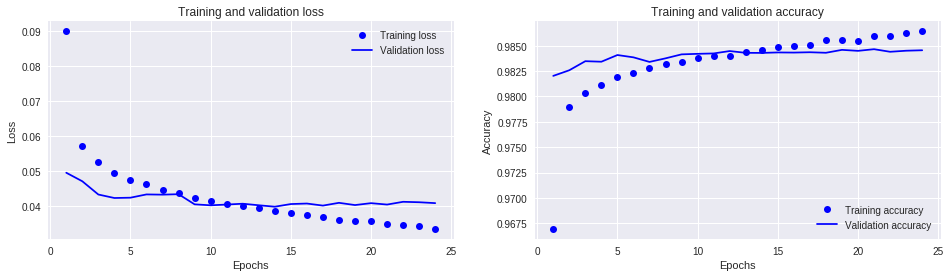

In [14]:
plot_history(history)

In [15]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 57s 2ms/step
([0.038422341863624025, 0.984991369282174], 0.9896267760427019)
